This lab on Decision Trees is a Python adaptation of p. 324-331 of "Introduction to Statistical Learning with
Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Original adaptation by J. Warmenhoven, updated by R. Jordan Crouser at Smith
College for SDS293: Machine Learning (Spring 2016).

http://www.science.smith.edu/~jcrouser/SDS293/

# Variance Importance


1.11.2.5. Feature importance evaluation: https://scikit-learn.org/stable/modules/ensemble.html#random-forest-feature-importance

The relative rank (i.e. depth) of a feature used as a decision node in a tree can be used to assess the relative importance of that feature with respect to the predictability of the target variable. Features used at the top of the tree contribute to the final prediction decision of a larger fraction of the input samples. The expected fraction of the samples they contribute to can thus be used as an estimate of the relative importance of the features. In scikit-learn, the fraction of samples a feature contributes to is combined with the decrease in impurity from splitting them to create a normalized estimate of the predictive power of that feature.

By averaging the estimates of predictive ability over several randomized trees one can reduce the variance of such an estimate and use it for feature selection. This is known as the mean decrease in impurity, or MDI. Refer to [L2014] for more information on MDI and feature importance evaluation with Random Forests.

4.2. Permutation feature importance: https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance


Permutation Importance vs Random Forest Feature Importance (MDI): https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

Individual decision trees intrinsically perform feature selection by selecting appropriate split points. This information can be used to measure the importance of each feature; the basic idea is: the more often a feature is used in the split points of a tree the more important that feature is. This notion of importance can be extended to decision tree ensembles by simply averaging the impurity-based feature importance of each tree (see Feature importance evaluation for more details). https://scikit-learn.org/stable/modules/ensemble.html#random-forest-feature-importance



In [1]:
import graphviz

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#import graphviz

%matplotlib inline

# 8.3.1 Fitting Classification Trees

The `sklearn` library has a lot of useful tools for constructing classification and regression trees:

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report

We'll start by using **classification trees** to analyze the `Carseats` data set. In these
data, `Sales` is a continuous variable, and so we begin by converting it to a
binary variable. We use the `ifelse()` function to create a variable, called
`High`, which takes on a value of `Yes` if the `Sales` variable exceeds 8, and
takes on a value of `No` otherwise. We'll append this onto our dataFrame using the `.map()` function, and then do a little data cleaning to tidy things up:

In [6]:
import os
cwd = os.getcwd()
print(cwd)
os.chdir('/Users/chenc/000---STT450-Jupyter Notebook/000--STT450-550/') 

C:\Users\Luke\000---STT592-Summer2022


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/Users/chenc/000---STT450-Jupyter Notebook/000--STT450-550/'

In [8]:
#df3 = pd.read_csv('Data/Carseats.csv').drop('Unnamed: 0', axis=1)
df3 = pd.read_csv('Data/Carseats.csv')
#df3.info()
print(); df3.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [9]:
df3['High'] = df3.Sales.map(lambda x: 1 if x>8 else 0)
df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]
df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
df3.US = df3.US.map({'No':0, 'Yes':1})
#df3.info()
print(); df3.head(5)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,1,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1,1
3,7.40,117,100,4,466,97,2,55,14,1,1,0
4,4.15,141,64,3,340,128,0,38,13,1,0,0


In order to properly evaluate the performance of a classification tree on
the data, we must estimate the test error rather than simply computing
the training error. We first split the observations into a training set and a test
set:

In [10]:
X = df3.drop(['Sales', 'High'], axis = 1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

We now use the `DecisionTreeClassifier()` function to fit a classification tree in order to predict
`High`. Unfortunately, manual pruning is not implemented in `sklearn`: http://scikit-learn.org/stable/modules/tree.html

However, we can limit the depth of a tree using the `max_depth` parameter:

In [14]:
classification_tree_carseats = DecisionTreeClassifier(max_depth = 6)
clf = classification_tree_carseats.fit(X_train, y_train)
classification_tree_carseats.score(X_train, y_train)

0.921875

We see that the training accuracy is 92.2%.

One of the most attractive properties of trees is that they can be
graphically displayed. Unfortunately, this is a bit of a roundabout process in `sklearn`. We use the `export_graphviz()` function to export the tree structure to a temporary `.dot` file,
and the `graphviz.Source()` function to display the image:

### Warning:
For Mac: In your anaconda terminal, run the following code:
conda install python-graphviz

If you run into some issues, you may need to some reference from this link:
https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft

In [12]:
## Only need to intall for the first time use:
# conda install python-graphviz

export_graphviz(classification_tree_carseats, 
                out_file = "carseat_tree.dot", 
                feature_names = X_train.columns) # out_file =None

with open("carseat_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

The most important indicator of `High` sales appears to be `Price`.

Finally, let's evaluate the tree's performance on
the test data. The `predict()` function can be used for this purpose. We can then build a confusion matrix, which shows that we are making correct predictions for
around 72.5% of the test data set:

In [17]:
pred = classification_tree_carseats.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, 
                  index = ['No', 'Yes'], 
                  columns = ['No', 'Yes'])
print(cm)
# (36+22)/80 = 0.725

     No  Yes
No   36   15
Yes   7   22


In [18]:
confusion_matrix(y_test, pred)

array([[36,  7],
       [15, 22]])

In [19]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77        43
           1       0.76      0.59      0.67        37

    accuracy                           0.73        80
   macro avg       0.73      0.72      0.72        80
weighted avg       0.73      0.72      0.72        80



# 8.3.2 Fitting Regression Trees

Now let's try fitting a **regression tree** to the `Boston` data set from the `MASS` library. First, we create a
training set, and fit the tree to the training data using `medv` (median home value) as our response:

In [20]:
boston_df = pd.read_csv('Data/Boston.csv')
X = boston_df.drop('medv', axis = 1)
y = boston_df.medv
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

# Pruning not supported. Choosing max depth 2)
regr_tree_boston = DecisionTreeRegressor(max_depth = 2)
regr_tree_boston.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

Let's take a look at the tree:

[Text(167.4, 181.2, 'X[13] <= 8.13\nmse = 85.144\nsamples = 404\nvalue = 22.612'),
 Text(83.7, 108.72, 'X[6] <= 7.437\nmse = 76.701\nsamples = 139\nvalue = 31.378'),
 Text(41.85, 36.23999999999998, 'mse = 37.749\nsamples = 115\nvalue = 28.55'),
 Text(125.55000000000001, 36.23999999999998, 'mse = 41.398\nsamples = 24\nvalue = 44.929'),
 Text(251.10000000000002, 108.72, 'X[13] <= 15.0\nmse = 28.117\nsamples = 265\nvalue = 18.014'),
 Text(209.25, 36.23999999999998, 'mse = 13.419\nsamples = 132\nvalue = 21.601'),
 Text(292.95, 36.23999999999998, 'mse = 17.259\nsamples = 133\nvalue = 14.453')]

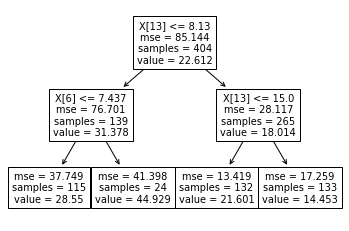

In [21]:
from sklearn import tree
tree.plot_tree(regr_tree_boston)

The variable `lstat` measures the percentage of individuals with lower
socioeconomic status. The tree indicates that lower values of `lstat` correspond
to more expensive houses. The tree predicts a median house price
of \$45,766 for larger homes (`rm>=7.4351`) in suburbs in which residents have high socioeconomic
status (`lstat<7.81`).

Now let's see how it does on the test data:

35.406215828790266

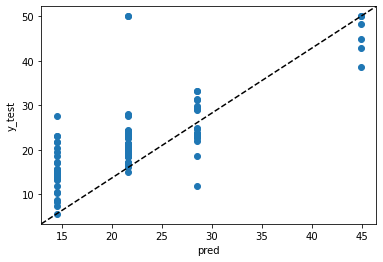

In [22]:
pred = regr_tree_boston.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'medv')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_squared_error(y_test, pred)

The test set MSE associated with the regression tree is
35.4. The square root of the MSE is therefore around 5.95, indicating
that this model leads to test predictions that are within around \$5,950 of
the true median home value for the suburb.
    
# 8.3.3 Bagging and Random Forests

Let's see if we can improve on this result using **bagging** and **random forests**. The exact results obtained in this section may
depend on the version of `python` and the version of the `RandomForestRegressor` package
installed on your computer, so don't stress out if you don't match up exactly with the book. Recall that **bagging** is simply a special case of
a **random forest** with $m = p$. Therefore, the `RandomForestRegressor()` function can
be used to perform both random forests and bagging. Let's start with bagging:

In [23]:
# Bagging: using all features
bagged_boston = RandomForestRegressor(max_features = 13, random_state = 1)
bagged_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=13, random_state=1)

The argument `max_features = 13` indicates that all 13 predictors should be considered
for each split of the tree -- in other words, that bagging should be done. How
well does this bagged model perform on the test set?

20.663406578431385

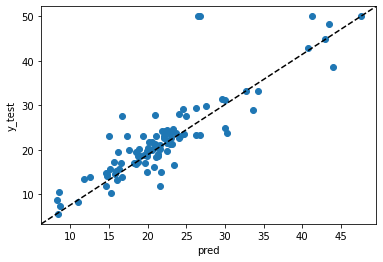

In [24]:
pred = bagged_boston.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'medv')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_squared_error(y_test, pred)

The test set MSE associated with the bagged regression tree is significantly lower than our single tree!

We can grow a random forest in exactly the same way, except that
we'll use a smaller value of the `max_features` argument. Here we'll
use `max_features = 6`:

In [25]:
# Random forests: using 6 features
random_forest_boston = RandomForestRegressor(max_features = 6, random_state = 1)

random_forest_boston.fit(X_train, y_train)

pred = random_forest_boston.predict(X_test)
mean_squared_error(y_test, pred)

22.37630496078432

The test set MSE is even lower; this indicates that random forests yielded an
improvement over bagging in this case.

Using the `feature_importances_` attribute of the `RandomForestRegressor`, we can view the importance of each
variable:

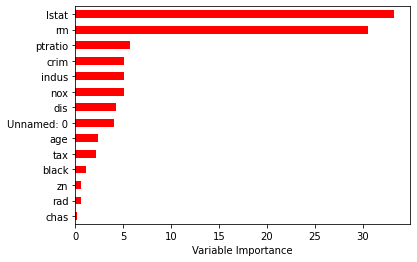

In [26]:
Importance = pd.DataFrame({'Importance':random_forest_boston.feature_importances_*100}, 
                          index = X.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

The results indicate that across all of the trees considered in the random
forest, the wealth level of the community (`lstat`) and the house size (`rm`)
are by far the two most important variables.

# 8.3.4 Boosting

Now we'll use the `GradientBoostingRegressor` package to fit **boosted
regression trees** to the `Boston` data set. The
argument `n_estimators = 500` indicates that we want 500 trees, and the option
`interaction.depth = 4` limits the depth of each tree:

In [27]:
boosted_boston = GradientBoostingRegressor(n_estimators = 500, 
                                           learning_rate = 0.01, 
                                           max_depth = 4, 
                                           random_state = 1)

boosted_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500,
                          random_state=1)

Let's check out the feature importances again:

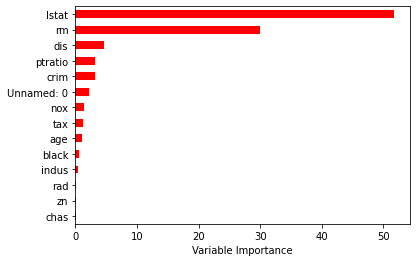

In [28]:
feature_importance = boosted_boston.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

We see that `lstat` and `rm` are again the most important variables by far. Now let's use the boosted model to predict `medv` on the test set:

In [29]:
mean_squared_error(y_test, boosted_boston.predict(X_test))

19.050652176784013

The test MSE obtained is similar to the test MSE for random forests
and superior to that for bagging. If we want to, we can perform boosting
with a different value of the shrinkage parameter $\lambda$. Here we take $\lambda = 0.2$:

In [30]:
boosted_boston2 = GradientBoostingRegressor(n_estimators = 500, 
                                            learning_rate = 0.2, 
                                            max_depth = 4, 
                                            random_state = 1)
boosted_boston2.fit(X_train, y_train)

mean_squared_error(y_test, boosted_boston2.predict(X_test))

17.8953232919065

In this case, using $\lambda = 0.2$ leads to a slightly lower test MSE than $\lambda = 0.01$.

To get credit for this lab, post your responses to the following questions:
 - What's one real-world scenario where you might try using Bagging?
 - What's one real-world scenario where you might try using Random Forests?
 - What's one real-world scenario where you might try using Boosting?
 
to Moodle: https://moodle.smith.edu/mod/quiz/view.php?id=264671